# LIME and its Variants Tutorials - GLIME

Previously in [LIME Tutorial Part1](https://github.com/PaddlePaddle/InterpretDL/blob/master/tutorials/LIME_Variants_part1.ipynb), we have shown how to use LIME in practice.

In this part of tutorial, we will give some analyses on LIME's stability and introduce alternatives of LIME.

## Classifying Images

The process is the same as in [Getting Started Tutorial](https://github.com/PaddlePaddle/InterpretDL/blob/master/tutorials/Getting_Started.ipynb).

In [33]:
import interpretdl as it
import paddle
device = 'gpu:0'
paddle.set_device(device)

print("Loading pretrained model.")
from paddle.vision.models import resnet101
paddle_model = resnet101(pretrained=True)
paddle_model.eval()

# !wget -c https://user-images.githubusercontent.com/13829174/171538910-f22c8207-f38d-4a7c-b6ce-43e2317e4941.jpeg -P ./assets/
img_path = 'assets/ILSVRC2012_val_00000293.jpeg'
img, data = it.data_processor.readers.images_transform_pipeline(img_path)

# !wget -c https://github.com/PaddlePaddle/InterpretDL/files/8561411/readable_label.txt -P ./assets/
f = open('assets/readable_label.txt', 'r')
lines = f.readlines()

# see the predicted top 5 probabilites
probability = paddle.nn.Softmax()(paddle_model(paddle.to_tensor(data)))
topvalues, top_ids = paddle.topk(probability, 5)

print('The model gives the predictions as follows:')
for cls_prob, cls_id in zip(topvalues[0].numpy(), top_ids[0].numpy()):
    print(f'\tprobability: {cls_prob:.5f} ({lines[cls_id].strip()})')

Loading pretrained model.
The model gives the predictions as follows:
	probability: 0.48697 (0 tench, Tinca tinca)
	probability: 0.29746 (391 coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch)
	probability: 0.03853 (149 dugong, Dugong dugon)
	probability: 0.03278 (394 sturgeon)
	probability: 0.02541 (390 eel)


## Stability between GLIME and LIME

Since LIME depends on the samples generated from the neiborhood of the local data point, the randomness is inevitable. Worse, when the `num_samples` is small, the quality of LIME explanation is affected.

First, let's see the instability from LIME. We use ResNet101 from `paddle.vision` and repeat the LIME explanations five times.

In [3]:
import paddle
from paddle.vision import resnet101
paddle_model = resnet101(pretrained=True)

100%|██████████| 500/500 [00:03<00:00, 135.21it/s]


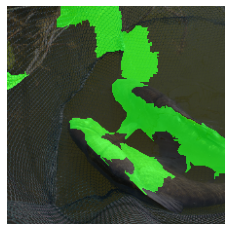

100%|██████████| 500/500 [00:03<00:00, 144.00it/s]


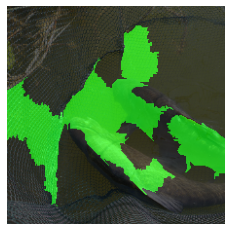

100%|██████████| 500/500 [00:03<00:00, 139.04it/s]


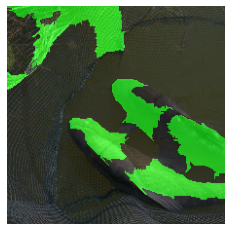

100%|██████████| 500/500 [00:03<00:00, 145.56it/s]


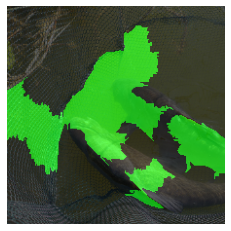

100%|██████████| 500/500 [00:03<00:00, 143.14it/s]


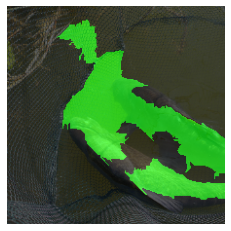

In [28]:
algo = it.LIMECVInterpreter(paddle_model)

for _ in range(5):
    lime_explanation = algo.interpret(img_path, num_samples=500, batch_size=100, resize_to=256, crop_to=224)

Though LIME can identify some of the important features/superpixels on the fish, the noises are very random, which affect the explanation quality. Note that we use a small number of samples (500), and use a larger number would decrease the randomness but the computation would increase.

We introduce an alternative, named GLIME, which is proposed by our team. We show that the stability and the explanation quality are significantly improved. The paper would be released soon.

Let's see the repeated results and introduce the details in the following.

Set Global Weights from /root/codespace/InterpretDL/work_dirs/imagenet_global_weights_avg.npy


/opt/conda/envs/pp2/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KMeans from version 0.22.1 when using version 0.24.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
100%|██████████| 500/500 [00:03<00:00, 132.51it/s]


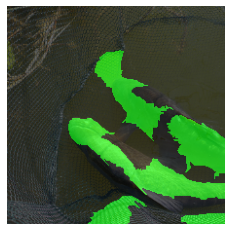

/opt/conda/envs/pp2/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KMeans from version 0.22.1 when using version 0.24.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
100%|██████████| 500/500 [00:03<00:00, 141.60it/s]


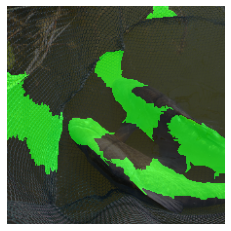

/opt/conda/envs/pp2/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KMeans from version 0.22.1 when using version 0.24.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
100%|██████████| 500/500 [00:03<00:00, 139.52it/s]


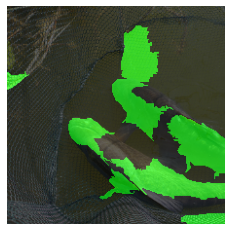

/opt/conda/envs/pp2/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KMeans from version 0.22.1 when using version 0.24.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
100%|██████████| 500/500 [00:03<00:00, 138.93it/s]


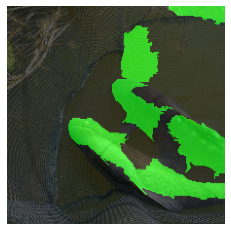

/opt/conda/envs/pp2/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KMeans from version 0.22.1 when using version 0.24.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
100%|██████████| 500/500 [00:03<00:00, 137.17it/s]


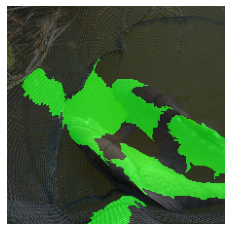

In [27]:
img_path = 'assets/ILSVRC2012_val_00000293.JPEG'
import interpretdl as it
algo = it.GLIMECVInterpreter(paddle_model)
algo.set_global_weights("/root/codespace/InterpretDL/work_dirs/imagenet_global_weights_avg.npy")

for _ in range(5):
    lime_explanation = algo.interpret(img_path, prior_method='ridge', prior_reg_force=2.0,
                                      num_samples=500, batch_size=100, resize_to=256, crop_to=224)

As we can see, there are still some noises but the randomness is largely decreased compared to LIME when using the same number of samples.

## LIME, NormLIME, GLIME: Local vs Global

LIME is known as a local explanation. This means that LIME explains a single data point only. This is reasonable for complex models, such as deep neural networks. 

However, global explanations have their advantages over local ones. For example, it is data independent, needs only once computation, and shows the general property of the model. But they are propably less accurate than local ones.

`GLIME` is a combination of local and global explanations. By introducing the prior knowledge of the global information, `GLIME` improves LIME through adding a regularization term when computing the proxy linear model at the local data points. Theoretical details will be introduced with the paper being public.

Here we introduce how to use `GLIME`.

### (Optional) Compute LIME Explanations
---

Because `GLIME` needs a global information, we use [NormLIME](https://arxiv.org/abs/1909.04200) or [AVG](https://arxiv.org/abs/1907.03039) as the aggregation of local explanations.

This can be done through `scripts/benchmark.py` using the command line:

```bash

data_list="/root/datasets/ImageNet/val/\*/\*.JPEG"  # ImageNet validation set path.
n=2000  # number of images for evaluation
s=3000  # number of samples for LIME

python ./scripts/benchmark.py --name imagenet --model resnet101 --num_classes 1000 --it lime --num_images $n --data_list $data_list --it_configs="{\"num_samples\": ${s}, \"top_k\": 5}"

```

This would save a `.npz` file where the LIME results and evaluation (deletion and insertion scores) are computed.

### (Optional) NormLIME and AVG Global Explanations
---

To facilate the usage of `GLIME`, we have already computed the LIME results and the aggregated global NormLIME and AVG explanations. 

The corresponding script to compute NormLIME and AVG explanations is as follows:

```python
import numpy as np
path = 'work_dirs/imagenet_resnet101_lime_2000.npz'
lime_results = dict(np.load(path, allow_pickle=True))
list_lime_results = [lime_results[img_path].item() for img_path in lime_results]

import paddle
from paddle.vision import resnet101
model = resnet101(pretrained=True, num_classes=1000)

import interpretdl as it
glime = it.GLIMECVInterpreter(model)

glime.compute_global_weights(g_name='normlime', list_of_lime_explanations=list_lime_results, save_path='work_dirs/imagenet_global_weights_normlime.npy')
# or glime.compute_global_weights(g_name='avg', list_of_lime_explanations=list_lime_results, save_path='work_dirs/imagenet_global_weights_avg.npy')
```

### GLIME Usage
---

Fortunately, once the `global_weights` computed, we do not need to repeat the previous two steps, including computing LIME results and aggregating them.

The step to use `GLIME` now is as simple as use LIME.

We just need one more step to set the global weights in advance, like this:

```python
algo = it.GLIMECVInterpreter(paddle_model)
algo.set_global_weights("/root/codespace/InterpretDL/work_dirs/imagenet_global_weights_avg.npy")
```

One more argument that distinguishes `GLIME` and `LIME` is the `prior_method` in the `interpret()` function. We need to set it to `ridge`.

## Next Step

This is the second part of `LIME and Its Variants`. In this tutorial, we introduced GLIME on the vision task. 

Note that LIME and GLIME can be applied to any differentiable models and any tasks, not limited in visual recognition. We have also the tutorials of NLP tasks, using 
[Ernie2.0 in English](https://github.com/PaddlePaddle/InterpretDL/blob/master/tutorials/ernie-2.0-en-sst-2.ipynb) ([on NBViewer](https://nbviewer.org/github/PaddlePaddle/InterpretDL/blob/master/tutorials/ernie-2.0-en-sst-2.ipynb)), 
[Bert in English](https://github.com/PaddlePaddle/InterpretDL/blob/master/tutorials/bert-en-sst-2.ipynb) ([on NBViewer](https://nbviewer.org/github/PaddlePaddle/InterpretDL/blob/master/tutorials/bert-en-sst-2.ipynb)), 
[BiLSTM in Chinese](https://github.com/PaddlePaddle/InterpretDL/blob/master/tutorials/bilstm-zh-chnsenticorp.ipynb) ([on NBViewer](https://nbviewer.org/github/PaddlePaddle/InterpretDL/blob/master/tutorials/bilstm-zh-chnsenticorp.ipynb)) and 
[Ernie1.0 in Chinese](https://github.com/PaddlePaddle/InterpretDL/blob/master/tutorials/ernie-1.0-zh-chnsenticorp.ipynb) ([on NBViewer](https://nbviewer.org/github/PaddlePaddle/InterpretDL/blob/master/tutorials/ernie-1.0-zh-chnsenticorp.ipynb)) as examples. For text visualizations, NBViewer gives better and colorful rendering results.

`GLIME` is also applicable for NLP tasks. We would deliver related tutorails in the future. Any suggestion and help are welcome.